<a href="https://colab.research.google.com/github/bksaini078/fake_news_detection/blob/master/MeanTeacher/MT_report_synonym.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**In** mean teacher model, we are creating embedding to find out most similar words or dissimilarwords from mean teacher vocabulary scope only. Adding unlabeled data increase the numberof words and also during adversarial training provides enough /new words to replace in labelleddata which increases syntactic accuracy

Author: Bhupender Kumar Saini

In [ ]:
#please install contractions 
import numpy as np
import re
import nltk
# import contractions
import string
import pandas as pd
import os
import numpy as np
import random
import spacy
import time
import re
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot


from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from gensim import utils 
from gensim.test.utils import get_tmpfile
from nltk.corpus import stopwords
import nltk
import en_core_web_sm
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer
import tensorflow as tf
import matplotlib.pyplot as plt
import datetime
from pathlib import Path

# nlp = en_core_web_sm.load()
# nltk.download('stopwords')
# nltk.download('punkt')
# porter=PorterStemmer()


In [ ]:
import tensorflow as tf 

import tensorflow.keras as tfk
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Lambda
from tensorflow.keras.models import Model
import numpy as np
import datetime
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.layers import *
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras import regularizers
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
#this is to enable eager execution
tf.compat.v1.enable_eager_execution()
path = '/content/drive/My Drive/Colab Notebooks/LatestData_July'
# path='/content/drive/My Drive/Colab Notebooks/lokesh_data'

# Tokenization

In [ ]:
def tokenization(x_train, x_test, x_unlabel, maxlen):

    from tensorflow.keras.preprocessing.text import Tokenizer
    from tensorflow.keras.preprocessing import sequence
    import numpy as np

    # max_features = 20000
    # maxlen = 100
    # batch_size = 32

    tokenizer = Tokenizer(num_words=None, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=' ',
                          char_level=False, oov_token=None, document_count=0)
    full_article = np.hstack((x_train, x_test, x_unlabel))
    tokenizer.fit_on_texts(full_article)
    x_train_token = tokenizer.texts_to_sequences(x_train)
    x_test_token = tokenizer.texts_to_sequences(x_test)
    x_unlabel_token = tokenizer.texts_to_sequences(x_unlabel)
    x_train_seq = sequence.pad_sequences(x_train_token, maxlen=maxlen,padding='post')
    x_test_seq = sequence.pad_sequences(x_test_token, maxlen=maxlen,padding='post')
    x_unlabel_tar= sequence.pad_sequences(x_unlabel_token, maxlen=maxlen,padding='post')
    # defining vocalbury size
    vocab_size = len(tokenizer.word_index) + 1

    x_train = x_train_seq
    x_test = x_test_seq
    return x_train, x_test , x_unlabel_tar, vocab_size, tokenizer

# Noise Creator 

In [ ]:
def instant_noise(x_train, y_train, x_unlabel, n_ratio ):
    '''this function introduce noise in the training data for mean teacher model , 
    this function is used in calculating classification cost, user have to provide 
    amount of noise, want to add(ratio) in train data and test train split ratio too'''
    #amount of noise need to add in x_train data 
    noise=int(np.shape(x_train)[0]*n_ratio)
 
    # taking column of x_train, need it later 
    x_column = np.shape(x_train)[1]

    if noise <= int(np.shape(x_unlabel)[0]):

        #taking number of noise from unlabel data 
        ratio_noise = x_unlabel[:noise]

        # creating -1 label for noise data 
        y_unlabel=np.full((np.shape(ratio_noise)[0], 1), -1)

        # adding noise in train data 
        x = np.append(x_train, ratio_noise, axis=0)
        # print(np.shape(x))
        y = np.append(y_train, y_unlabel, axis=0)
        x = np.append(x,y, axis=1)
        row = np.shape(x)[0]

        # shufflin data 
        x =np.random.permutation(x)
        # print(np.shape(x))

        #seperating label from x 
        y_train_n=np.reshape(x[:,x_column],(row,1))
        x_train_n=x[0:len(x),0:x_column]
        # y_train_n= np.reshape(y[:len(x),0],(train_split,1))

        
    else :
        print('error: Insufficient unlabel data available !')

    return x_train_n, y_train_n


In [ ]:
from tensorflow.keras.preprocessing import sequence
from nltk import WordPunctTokenizer
from gensim.models.fasttext import FastText

# this function is to learn embedding 

def embedding_creation(full_article):
    word_punctuation_tokenizer = nltk.WordPunctTokenizer()
    word_tokenized_corpus = [word_punctuation_tokenizer.tokenize(sent) for sent in full_article]
    embedding_size = 60
    window_size = 40
    min_word = 5
    down_sampling = 1e-2
    embedd_model = FastText(word_tokenized_corpus,
                      size=embedding_size,
                      window=window_size,
                      min_count=min_word,
                      sample=down_sampling,
                      sg=0,
                      iter=50)
    print('Finished and saving model at location', path)
    embedd_model.save(path+'embedding_Model.model')
    return 


def synonym_noise(x_batch,maxlen,tokenizer):
    articles = tokenizer.sequences_to_texts(x_batch)
    changed_articles=[]
    model_embedd= FastText.load( path+'/embedding.model')
    for article in articles:
        word_array= article.split(' ')
        sent1=[]
        '''toss and taking random decision on data'''
        if np.random.binomial(1, 0.5):
            for word in word_array:
                if word in model_embedd.wv.vocab:
                    most_similar=model_embedd.wv.most_similar(word)
                    # print(most_similar[0][0])
                    #flipping coin to decide to change or not if head change word and if tails dont change
                    #change p value for reducing or increasing the edit 
                    if np.random.binomial(1, 0.3):
                        sent1.append(most_similar[0][0])
                    else:
                        sent1.append(word)
                else:
                    sent1.append(word)
            joined_text = ' '.join(sent1)
        else:
            joined_text=' '.join(word_array)
        changed_articles.append(joined_text)
    x_train_seq_n = tokenizer.texts_to_sequences(changed_articles)
    x_train_seq_n = sequence.pad_sequences(x_train_seq_n,maxlen=maxlen, padding='post')
    x_train_seq_n=tf.convert_to_tensor(x_train_seq_n)
    return x_train_seq_n

# Model Declaration



In [ ]:
def BiLstmModel(maxlen, vocab_size):
  tf.keras.backend.clear_session()
  inputs = keras.Input(shape=(maxlen,))
  x =Embedding(vocab_size, 128, input_length=None)(inputs)
  x =Bidirectional(LSTM(128))(x)
#   x = Dropout(0.2)(x)
#   x =Dense(64,activation='relu')(x)
  x =Dense(2)(x)
  x =Dense(1, activation='sigmoid')(x)
  return Model(inputs,x)


# Evaluation Functions

In [ ]:

#Function to create confusion matrix 
def Confusion_matrix(model,x_test,y_true, threshold, caption='Confusion matrix'):
    '''this function will create confusion matrix with predicted value and true label'''
    y_hat= model.predict(x_test)
    y_pred=(np.greater_equal(y_hat,threshold)).astype(int)
    cm=confusion_matrix(y_true,y_pred)
    # print(cm)
    # calculating recall , precision and f1 score 
    tp_and_fp=np.sum(cm[:,1])
    tn_and_fp=np.sum(cm[0,:])
    tp_and_fn = np.sum(cm[1, : ])
    tp_and_tn= np.trace(cm)
    tp=(tp_and_fp-tn_and_fp+tp_and_tn)/2
    '''handling with divide by zero is pending'''
    #TODO: handling of divide by zero 
    precision=tp/tp_and_fp 
    recall = tp/tp_and_fn
    accuracy= np.trace(cm)/np.sum(cm)
    # f1_score=sklearn.metrics.f1_score(y_true, y_pred)
  
    f1_score= (2*precision*recall)/(precision+recall)
    print('Precision:', precision)
    print('Recall:', recall)
    print('f1 Score:', f1_score)
    print('Accuracy:', accuracy)

    # import matplotlib.pyplot as plt
    # figure = plt.figure(figsize=(8, 8))
    # # cm=np.around(cm.astype(int))
    # # con_mat_norm = np.around(cm, decimals=4)
    # con_mat_norm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
    # sns.heatmap(con_mat_norm, annot=True,cmap=plt.cm.Oranges)
    # plt.tight_layout()
    # plt.ylabel('True label')
    # plt.xlabel('Predicted label')
    # plt.title(caption)
    
    # plt.show()
    return cm, accuracy, precision, recall, f1_score

def prec_rec_f1score(y_true,x_test,model):
    from sklearn.metrics import precision_recall_fscore_support
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import precision_score
    from sklearn.metrics import recall_score
    from sklearn.metrics import f1_score
    from sklearn.metrics import accuracy_score
    bce = tf.keras.losses.BinaryCrossentropy()

    y_hat= model.predict(x_test)
    y_pred=(np.greater_equal(y_hat,0.51)).astype(int)
    pr_re_f1score_perclass= precision_recall_fscore_support(y_true, y_pred, average=None)
    pr_re_f1score_average=precision_recall_fscore_support(y_true, y_pred, average='micro')
    precision=precision_score(y_true,y_pred,average=None)
    recall = recall_score(y_true,y_pred,average=None)
    accuracy= accuracy_score(y_true,y_pred)
    f1_score=f1_score(y_true,y_pred)
    #per class
    precision_true=pr_re_f1score_perclass[0][1]
    precision_fake=pr_re_f1score_perclass[0][0]
    recall_true=pr_re_f1score_perclass[1][1]
    recall_fake=pr_re_f1score_perclass[1][0]
    f1score_true= pr_re_f1score_perclass[2][1]
    f1score_fake= pr_re_f1score_perclass[2][0]
    metrices_name=['accuracy','precision_true','precision_fake','recall_true','recall_fake','f1score_true','f1score_fake']
    metrices_value=[accuracy, precision_true, precision_fake, recall_true, recall_fake, f1score_true, f1score_fake]
    i=0
    for item in metrices_name:
        print(item +':',metrices_value[i])
        i+=1
    binary_loss= bce(y_true, y_hat).numpy()
    print('Binary_loss',binary_loss)
    return accuracy, precision_true, precision_fake, recall_true, recall_fake, f1score_true, f1score_fake,binary_loss



In [ ]:
import matplotlib.pyplot as plt
def scatter_plot(logits, y_t, title):
    marker_size=20
    figure = plt.figure(figsize=(20, 6))
    plt.scatter(logits,logits, marker_size, c=y_t)
    plt.title(title)
    plt.xlabel("Predicted Probability")
    plt.ylabel("Predicted Probability")
    cbar= plt.colorbar()
    cbar.set_label("Probability", labelpad=+1)
    plt.show()
    return

# accuracy 
def model_evaluation(model, x_test, y_true, name):
    y_hat= model(x_test)
    y_pred=(np.greater(y_hat,0.51)).astype(int)
    cm=confusion_matrix(y_true,y_pred)
    
    accuracy= np.trace(cm)/np.sum(cm)
    
    print(name+ ":")
  
    print(' Accuracy:', accuracy)

    # this will plot the result 
    # scatter_plot(y_hat,y_true, title=name)

    return accuracy #precision, recall, f1_score, accuracy
def plot_roc(fpr,tpr,label):
    #  plot the roc curve for the model
    pyplot.plot(fpr, tpr, linestyle='--', label=label)

    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    # show the legend
    pyplot.legend()
    # show the plot 
    pyplot.show()
    return

# Cost Functions

In [ ]:
# declaring loss function
# ref:https://github.com/CuriousAI/mean-teacher/tree/master/tensorflow/mean_teacher  updated according to our need .
def classification_costs(logits, labels):
    """ Commputing classification cost , after removing labels -1 of unlabelled data and then calculating 
    the binary cross entropy .
    """
    applicable = tf.not_equal(labels, -1)

     # Change -1s to zeros to make cross-entropy computable
    labels = tf.where(applicable, labels, tf.zeros_like(labels))

    # This will now have incorrect values for unlabeled examples
    per_sample = tf.keras.losses.binary_crossentropy(labels,logits)
    # Retain costs only for labeled
    per_sample = tf.where(applicable, per_sample, tf.zeros_like(per_sample))
    # Take mean over all examples, not just labeled examples.
    # print('sample', np.shape(per_sample))
    loss = tf.math.divide( tf.reduce_mean(tf.reduce_sum(per_sample)), np.shape(per_sample)[0])

    return loss

#custom loss function
def Overall_Cost(classification_cost, consistency_cost, ratio=0.5):
    return (ratio * classification_cost) + ((1 - ratio)*consistency_cost)
#function for consistency cost 
def Consistency_Cost(teacher_output, student_output):
    #Kl divergence 
    # kl = tf.keras.losses.KLDivergence()
    # sq_diff_layer=kl(teacher_output, student_output).numpy()
    
    #MSE
    sq_diff_layer = tf.reduce_mean(tf.math.squared_difference(teacher_output, student_output))
    return sq_diff_layer
def ema(student_model, teacher_model, alpha):
    '''
    Calculates the exponential moving average of the student model weights and updates the teacher model weights
    formula:
    t_i = alpha * t_{i-1} + (1 - alpha) * s_i, with default alpha = 0.99
    t_i = weights of teacher model in current epoch
    s_i = weights of student model in current epoch
    '''
    #taking weights 
    student_weights = student_model.get_weights()
    teacher_weights = teacher_model.get_weights()

    #length must be equal otherwise it will not work 
    assert len(student_weights) == len(teacher_weights), 'length of student and teachers weights are not equal Please check. \n Student: {}, \n Teacher:{}'.format(
        len(student_weights), len(teacher_weights))

    new_layers = []
    for i, layers in enumerate(student_weights):
        new_layer = alpha*(teacher_weights[i]) + (1-alpha)*layers
        new_layers.append(new_layer)
    teacher_model.set_weights(new_layers)
    return teacher_model


# Writing Report

In [ ]:

def report_writing( Model,lr,Batch_Size, Epoch,Alpha,Ratio, train_accuracy,test_accuracy,precision_true,precision_fake,recall_true,recall_fake,f1score_true,f1score_fake,Classification_Loss,comment):
    x = datetime.datetime.now()
    report_df = pd.DataFrame(columns=['Date', 'Model','Learning Rate','Batch_Size', 'Epoch','Alpha','Ratio','Train_Accuracy',
                                      'Test_Accuracy', 'Precision_True','Precision_Fake','Recall_True','Recall_Fake','F1_Score_True','F1_Score_Fake','Classification_Loss',
                                      'comment'])
    report_df = report_df.append({'Date' : x.strftime("%c"), 'Model' :Model,'Learning Rate':lr,'Batch_Size' : Batch_Size, 'Epoch': Epoch,'Alpha': Alpha,'Ratio': Ratio,'Train_Accuracy': train_accuracy,
                                  'Test_Accuracy': test_accuracy, 'Precision_True': precision_true,'Precision_Fake': precision_fake,'Recall_True': recall_true,'Recall_Fake': recall_fake,'F1_Score_True': f1score_true,'F1_Score_Fake': f1score_fake,'Classification_Loss':Classification_Loss,'comment': comment}, ignore_index=True)
    my_file = Path(path+'/report_supervised_0.99_10fold_2.csv')

    if my_file.exists():
        report_df.to_csv(path+'/report_supervised_0.99_10fold_2.csv',mode='a', header= False , index = False)
    else:
        report_df.to_csv(path+'/report_supervised_0.99_10fold_2.csv',mode='w', header= True , index= False) 
    return 

# report_writing('Supervised-BiLstm', 124,10,34, 0.5, 0.99,0.90,0.90,0.90)

# Loading data 

In [ ]:

def loading_data():
    if not os.path.isfile(path+'/xte_shuffled.npy'):
        print("Please clean the data first or the location of npy file is incorrect, Checking function Loading_data")
    else:
      x_tr = np.load(path+'/xtr_shuffled.npy',allow_pickle=True)
      x_te = np.load(path+'/xte_shuffled.npy',allow_pickle=True)
      y_tr = np.load(path+'/ytr_shuffled.npy',allow_pickle=True)
      y_te = np.load(path+'/yte_shuffled.npy',allow_pickle=True)
      x_un = np.load(path+'/xun_shuffled.npy',allow_pickle=True)
    #   print("train Data_Size:",  np.shape(x_tr))
    #   print("test Data_Size:",  np.shape(x_te))
      


      # Performing Kfold here 
    return x_tr, y_tr, x_te, y_te, x_un


def Kfold_crossvalidation(x_train,y_train,x_test,y_test):
    '''this function is for k_fold crossvalidation implementation'''
    from sklearn.model_selection import train_test_split
    data= np.append(x_train, x_test, axis=0)
    label= np.append(y_train,y_test, axis=0)
    label= np.reshape(label,(len(label),1))
    column_size= np.shape(data)[1]
    # combining whole data
    whole_data=np.append(data,label.astype(int),axis=1)
    whole_data= np.random.permutation(whole_data)
    whole_label= whole_data[:][:,-1:]
    whole_data= whole_data[:][:,:column_size]
    x_tr, x_te, y_tr, y_te = train_test_split(whole_data, whole_label, test_size=0.33)
    return x_tr, y_tr, x_te, y_te

# Supervised Model

In [ ]:


def train_supervised(epochs, batch_size, lr, x_train, y_train, x_test, y_test,maxlen,vocab_size):    
    model_supervised = BiLstmModel(maxlen, vocab_size)
    model_supervised.compile(optimizer= tf.keras.optimizers.Adam(learning_rate= lr ),loss= 'binary_crossentropy', metrics=['accuracy'])
    print('Training supervised Model...')
    history=model_supervised.fit(x_train, y_train,batch_size=batch_size,epochs=epochs,validation_split=0.25)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()  

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    # evaluation
    train_accuracy=history.history['accuracy'][len(history.epoch)-1]
    fpr=[]
    tpr=[]
    y_pred = model_supervised.predict(x_test)
    fpr_, tpr_, _ = roc_curve(y_test, y_pred)
    plot_roc(fpr_,tpr_,'supervised model')
    fpr.append(fpr_)
    tpr.append(tpr_)
    np.save(path+'/roc/fpr_supervised',fpr)
    np.save(path+'/roc/tpr_supervised',tpr)

    test_accuracy,precision_true,precision_fake,recall_true,recall_fake,f1score_true,f1score_fake,binary_loss = prec_rec_f1score(y_test,x_test,model_supervised)
    # cm, test_accuracy, precision, recall, f1_score =Confusion_matrix(model_supervised,x_test,y_test,0.51, 'Supervised model')
    report_writing('Supervised_BILSTM',lr, batch_size,len(history.epoch),'NaN','NaN', train_accuracy, 
                   test_accuracy, precision_true, precision_fake, recall_true, recall_fake, 
                   f1score_true, f1score_fake,binary_loss,'changed stemming while preprocessing')    



# MEAN teacher
In this updation takes place during each step/batch. This model doesnt work 

In [ ]:
 def train_MeanTeacher(epochs, batch_size, alpha, lr, ratio,x_train, y_train, x_test, y_test, x_unlabel_tar,vocab_size, tokenizer,maxlen):
  

    # splitting training data 
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25)

    #preparing the training dataset
    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)


    #preparing the target dataset 
    tar_dataset =  tf.data.Dataset.from_tensor_slices(x_unlabel_tar)
    tar_dataset = tar_dataset.shuffle(buffer_size=1024).batch(batch_size)

    #declaring optimiser
    optimizer= tf.keras.optimizers.Adam(learning_rate= lr ) #trying changing learning rate , sometimes it gives good result 
    train_metrics = tf.keras.metrics.BinaryAccuracy(name='Binary_Accuracy')
    val_acc_metric = tf.keras.metrics.BinaryAccuracy(name="Binary_Acc")
    teacher_acc_metric = tf.keras.metrics.BinaryAccuracy(name="Binary_Acc_teacher") 
    # Creating model
    student = BiLstmModel(maxlen, vocab_size)
    teacher = BiLstmModel(maxlen, vocab_size)



    train_accuracy=[]
    steps=[]

    # iterator_unlabel = iter(tar_dataset)
    val_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
    val_dataset = val_dataset.batch(batch_size)

    #training teacher with one epoch 
   
    #this I am doing to get all steps details in epoch
    i=0
    print('Train Mean teacher Model...')
    teacher.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),loss=tf.keras.losses.BinaryCrossentropy(),metrics=['accuracy'])
    teacher.fit(x_train,y_train, batch_size=batch_size, epochs=1)

    acc_t=0
    #false positive rate and true positive rate
    fpr=[]
    tpr=[]
    
    for epoch in range(1,epochs+1):  
        print(*"*****************")
        print('Start of epoch %d' % (epoch,))
        print(*"*****************")
        #iteration over batches 
        for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
             with tf.GradientTape() as tape:
         
            
                '''this is related to change with synonyms in articles'''
                x_batch_sn= synonym_noise(x_batch_train.numpy(),maxlen,tokenizer)

                '''this is one method of adding -1 label using unlable data'''
                # x_train_n,y_train_n= instant_noise(x_batch_train,y_batch_train,x_batch_unlabel,0.2)

                # Run the forward pass of the layer
                logits= student(x_batch_sn, training= True)  
                # logits_acc =  student(x_batch_sn, training= False) 

                # TODO:this  metrics also have to right 
                train_metrics(y_batch_train,logits)  

                #Calculating classification cost 
                classification_cost = classification_costs(logits,y_batch_train)
                # classification.append(classification_cost)
         
                #calculating consistency cost for unlabelled dataset
                '''experiment and check'''
                

                x_batch_sn1= synonym_noise(x_batch_train.numpy(),maxlen,tokenizer)
                
                # tar_student= student(x_batch_sn)
                tar_teacher = teacher(x_batch_sn1) #x_batch_train
                #  tar_student= student(x_train_n)
                consistency_cost= Consistency_Cost(tar_teacher,logits) 
                # consistency.append(consistency_cost)

                overall_cost= Overall_Cost(classification_cost, consistency_cost, ratio=0.5)
                
                #adding loss to student model 
             grads= tape.gradient(overall_cost, student.trainable_weights)
             i=i+1
             steps.append(i)
   
             # the value of the variables to minimize the loss.
             optimizer.apply_gradients(zip(grads, student.trainable_weights))
             teacher= ema(student, teacher, alpha=alpha)

        train_acc = train_metrics.result()
        print(alpha)
   
        #appending training accuracy
        train_accuracy.append(train_acc)

        # print('Training acc over epoch: %s' % (float(train_acc)*100,))
        # Reset training metrics at the end of each epoch
        train_metrics.reset_states()
   
        # Run a validation loop at the end of each epoch.
        print('*******STUDENT*************')
        prec_rec_f1score(y_val,x_val,student)
        print('*******TEACHER*************')
        prec_rec_f1score(y_val,x_val,teacher)


 
        if epoch >= 10 and epoch % 5 ==0 :
            print('---------------------------STUDENT--------------------------')
            test_accuracy,precision_true,precision_fake,recall_true,recall_fake,f1score_true,f1score_fake,binary_loss = prec_rec_f1score(y_test,x_test,student)
            report_writing('Student',lr, batch_size,epoch,alpha,ratio, train_acc.numpy(), 
                           test_accuracy, precision_true, precision_fake, recall_true, recall_fake, 
                           f1score_true, f1score_fake,binary_loss,'Noise-using-synonym')
              
            
            print('-----------------------------------------------------------------')
    
            print('---------------------------TEACHER---------------------------------')
        #    cm, test_accuracy, precision, recall, f1_score =Confusion_matrix(teacher,x_test,y_test,0.51, 'Teacher model')
            test_accuracy,precision_true,precision_fake,recall_true,recall_fake,f1score_true,f1score_fake,binary_loss = prec_rec_f1score(y_test,x_test,teacher)
            report_writing('Teacher',lr, batch_size,epoch,alpha,ratio, train_acc.numpy(), 
                           test_accuracy, precision_true, precision_fake, recall_true, recall_fake, 
                           f1score_true, f1score_fake,binary_loss,'Noise-using-synonym') 
            y_pred = teacher.predict(x_test)
            fpr_, tpr_, _ = roc_curve(y_test, y_pred)
            plot_roc(fpr_,tpr_,'MeanTeacher-synonym')
            fpr.append(fpr_)
            tpr.append(tpr_)
            print('-----------------------------------------------------------------')

    np.save(path+'/roc/fpr_synonym',fpr)
    np.save(path+'/roc/tpr_synonym',tpr)
    tf.keras.backend.clear_session()
    return teacher

    

# main function

train Data_Size: (2189, 100)
test Data_Size: (244, 100)
Train Label count: True, Fake 1131 1058
Test Label count : True, Fake 128 116
Training supervised Model...
Epoch 1/15
26/26 [==============================] - 13s 507ms/step - loss: 0.6927 - accuracy: 0.5381 - val_loss: 0.6920 - val_accuracy: 0.5803
Epoch 2/15
26/26 [==============================] - 12s 473ms/step - loss: 0.6915 - accuracy: 0.5990 - val_loss: 0.6914 - val_accuracy: 0.5839
Epoch 3/15
26/26 [==============================] - 12s 473ms/step - loss: 0.6899 - accuracy: 0.6350 - val_loss: 0.6895 - val_accuracy: 0.6150
Epoch 4/15
26/26 [==============================] - 12s 476ms/step - loss: 0.6868 - accuracy: 0.6466 - val_loss: 0.6870 - val_accuracy: 0.6168
Epoch 5/15
26/26 [==============================] - 12s 477ms/step - loss: 0.6769 - accuracy: 0.6344 - val_loss: 0.6750 - val_accuracy: 0.5821
Epoch 6/15
26/26 [==============================] - 12s 471ms/step - loss: 0.6274 - accuracy: 0.6691 - val_loss: 0.6202 - 

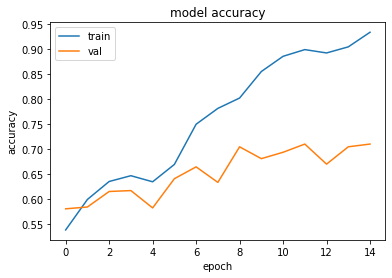

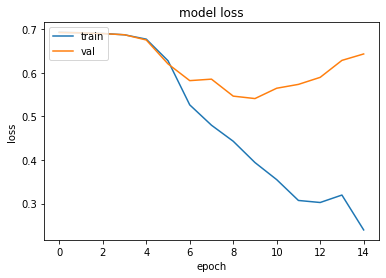

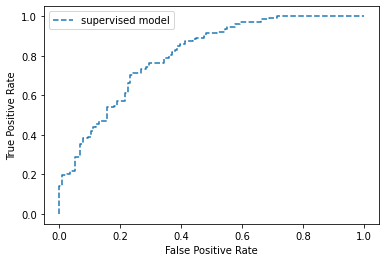

accuracy: 0.7254098360655737
precision_true: 0.7520661157024794
precision_fake: 0.6991869918699187
recall_true: 0.7109375
recall_fake: 0.7413793103448276
f1score_true: 0.7309236947791166
f1score_fake: 0.7196652719665272
Binary_loss 0.61032736
train Data_Size: (2189, 100)
test Data_Size: (244, 100)
Train Label count: True, Fake 1129 1060
Test Label count : True, Fake 130 114
Training supervised Model...
Epoch 1/15
26/26 [==============================] - 13s 503ms/step - loss: 0.6931 - accuracy: 0.5149 - val_loss: 0.6920 - val_accuracy: 0.5566
Epoch 2/15
26/26 [==============================] - 12s 472ms/step - loss: 0.6905 - accuracy: 0.5728 - val_loss: 0.6890 - val_accuracy: 0.5858
Epoch 3/15
26/26 [==============================] - 12s 474ms/step - loss: 0.6866 - accuracy: 0.6350 - val_loss: 0.6877 - val_accuracy: 0.6095
Epoch 4/15
26/26 [==============================] - 12s 472ms/step - loss: 0.6784 - accuracy: 0.6795 - val_loss: 0.6792 - val_accuracy: 0.6350
Epoch 5/15
26/26 [====

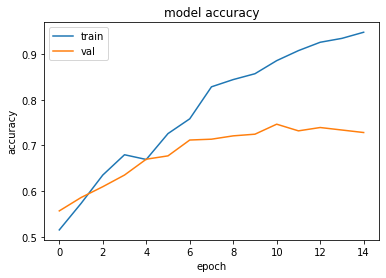

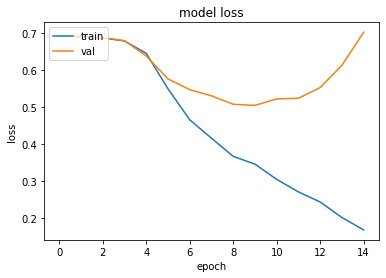

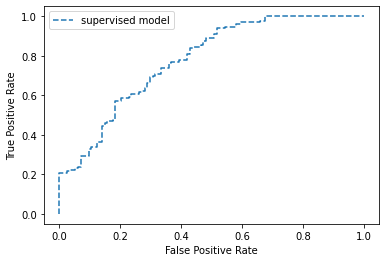

accuracy: 0.6967213114754098
precision_true: 0.7258064516129032
precision_fake: 0.6666666666666666
recall_true: 0.6923076923076923
recall_fake: 0.7017543859649122
f1score_true: 0.7086614173228347
f1score_fake: 0.6837606837606838
Binary_loss 0.8549504
train Data_Size: (2189, 100)
test Data_Size: (244, 100)
Train Label count: True, Fake 1131 1058
Test Label count : True, Fake 128 116
Training supervised Model...
Epoch 1/15
26/26 [==============================] - 13s 504ms/step - loss: 0.6929 - accuracy: 0.5210 - val_loss: 0.6919 - val_accuracy: 0.5639
Epoch 2/15
26/26 [==============================] - 12s 470ms/step - loss: 0.6914 - accuracy: 0.5777 - val_loss: 0.6904 - val_accuracy: 0.5785
Epoch 3/15
26/26 [==============================] - 12s 474ms/step - loss: 0.6897 - accuracy: 0.6258 - val_loss: 0.6894 - val_accuracy: 0.5967
Epoch 4/15
26/26 [==============================] - 12s 474ms/step - loss: 0.6867 - accuracy: 0.6405 - val_loss: 0.6868 - val_accuracy: 0.6131
Epoch 5/15
26/

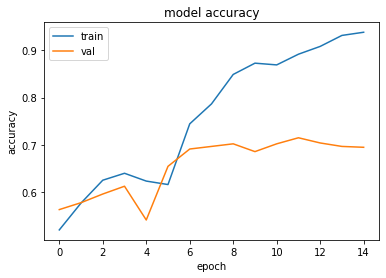

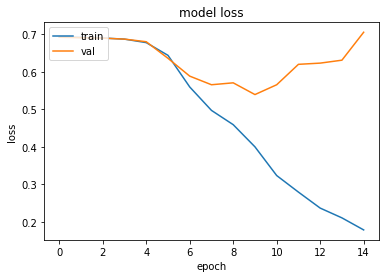

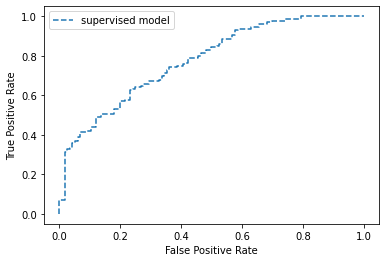

accuracy: 0.680327868852459
precision_true: 0.6582278481012658
precision_fake: 0.7209302325581395
recall_true: 0.8125
recall_fake: 0.5344827586206896
f1score_true: 0.7272727272727273
f1score_fake: 0.6138613861386139
Binary_loss 0.79315954
train Data_Size: (2190, 100)
test Data_Size: (243, 100)
Train Label count: True, Fake 1131 1059
Test Label count : True, Fake 128 115
Training supervised Model...
Epoch 1/15
26/26 [==============================] - 13s 501ms/step - loss: 0.6929 - accuracy: 0.5030 - val_loss: 0.6908 - val_accuracy: 0.5456
Epoch 2/15
26/26 [==============================] - 12s 471ms/step - loss: 0.6900 - accuracy: 0.5901 - val_loss: 0.6899 - val_accuracy: 0.5712
Epoch 3/15
26/26 [==============================] - 12s 472ms/step - loss: 0.6866 - accuracy: 0.6303 - val_loss: 0.6879 - val_accuracy: 0.5821
Epoch 4/15
26/26 [==============================] - 12s 470ms/step - loss: 0.6772 - accuracy: 0.6236 - val_loss: 0.6815 - val_accuracy: 0.5529
Epoch 5/15
26/26 [========

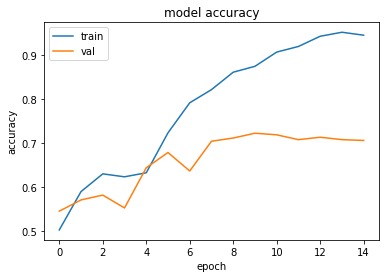

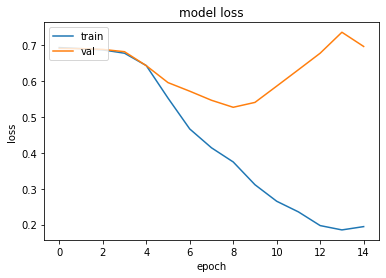

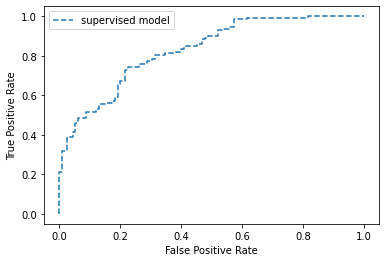

accuracy: 0.7407407407407407
precision_true: 0.76
precision_fake: 0.7203389830508474
recall_true: 0.7421875
recall_fake: 0.7391304347826086
f1score_true: 0.7509881422924901
f1score_fake: 0.7296137339055793
Binary_loss 0.5805906
train Data_Size: (2190, 100)
test Data_Size: (243, 100)
Train Label count: True, Fake 1142 1048
Test Label count : True, Fake 117 126
Training supervised Model...
Epoch 1/15
26/26 [==============================] - 13s 504ms/step - loss: 0.6916 - accuracy: 0.5524 - val_loss: 0.6898 - val_accuracy: 0.5858
Epoch 2/15
26/26 [==============================] - 12s 474ms/step - loss: 0.6883 - accuracy: 0.6011 - val_loss: 0.6880 - val_accuracy: 0.5967
Epoch 3/15
26/26 [==============================] - 12s 476ms/step - loss: 0.6852 - accuracy: 0.6261 - val_loss: 0.6861 - val_accuracy: 0.5858
Epoch 4/15
26/26 [==============================] - 12s 474ms/step - loss: 0.6779 - accuracy: 0.6480 - val_loss: 0.6821 - val_accuracy: 0.5949
Epoch 5/15
26/26 [===================

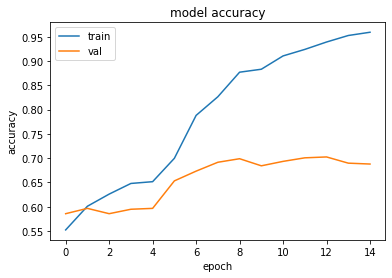

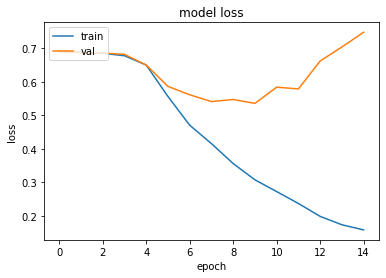

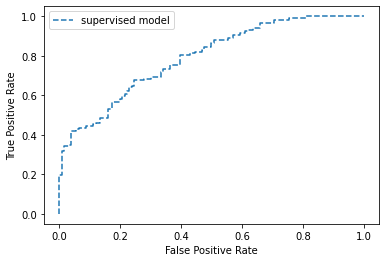

accuracy: 0.691358024691358
precision_true: 0.6438356164383562
precision_fake: 0.7628865979381443
recall_true: 0.8034188034188035
recall_fake: 0.5873015873015873
f1score_true: 0.714828897338403
f1score_fake: 0.6636771300448431
Binary_loss 0.7828666
train Data_Size: (2190, 100)
test Data_Size: (243, 100)
Train Label count: True, Fake 1142 1048
Test Label count : True, Fake 117 126
Training supervised Model...
Epoch 1/15
26/26 [==============================] - 13s 503ms/step - loss: 0.6926 - accuracy: 0.5207 - val_loss: 0.6914 - val_accuracy: 0.5693
Epoch 2/15
26/26 [==============================] - 12s 476ms/step - loss: 0.6914 - accuracy: 0.5457 - val_loss: 0.6902 - val_accuracy: 0.5584
Epoch 3/15
26/26 [==============================] - 12s 474ms/step - loss: 0.6898 - accuracy: 0.5652 - val_loss: 0.6887 - val_accuracy: 0.5858
Epoch 4/15
26/26 [==============================] - 12s 474ms/step - loss: 0.6855 - accuracy: 0.6255 - val_loss: 0.6832 - val_accuracy: 0.6223
Epoch 5/15
26/26

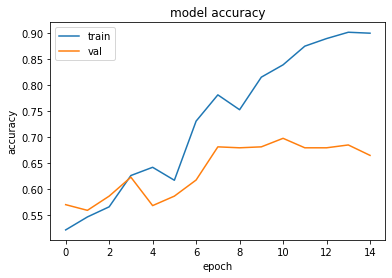

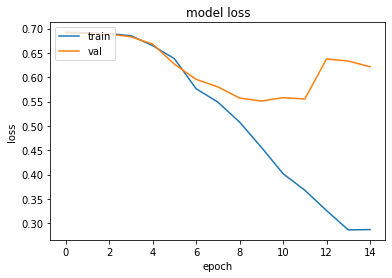

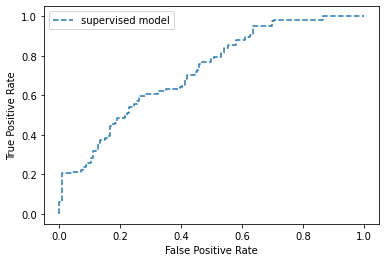

accuracy: 0.6296296296296297
precision_true: 0.5838509316770186
precision_fake: 0.7195121951219512
recall_true: 0.8034188034188035
recall_fake: 0.46825396825396826
f1score_true: 0.6762589928057554
f1score_fake: 0.5673076923076924
Binary_loss 0.71176696
train Data_Size: (2190, 100)
test Data_Size: (243, 100)
Train Label count: True, Fake 1144 1046
Test Label count : True, Fake 115 128
Training supervised Model...
Epoch 1/15
26/26 [==============================] - 13s 514ms/step - loss: 0.6923 - accuracy: 0.5347 - val_loss: 0.6905 - val_accuracy: 0.5675
Epoch 2/15
26/26 [==============================] - 12s 478ms/step - loss: 0.6902 - accuracy: 0.5816 - val_loss: 0.6889 - val_accuracy: 0.5876
Epoch 3/15
26/26 [==============================] - 12s 477ms/step - loss: 0.6877 - accuracy: 0.6248 - val_loss: 0.6875 - val_accuracy: 0.6277
Epoch 4/15
26/26 [==============================] - 12s 480ms/step - loss: 0.6828 - accuracy: 0.6553 - val_loss: 0.6839 - val_accuracy: 0.6204
Epoch 5/15
2

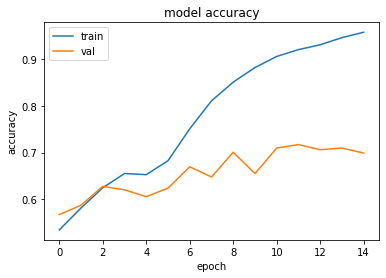

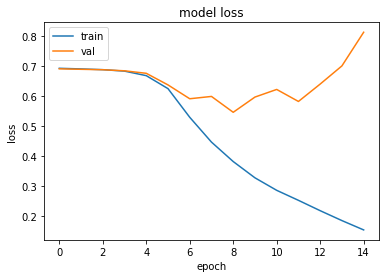

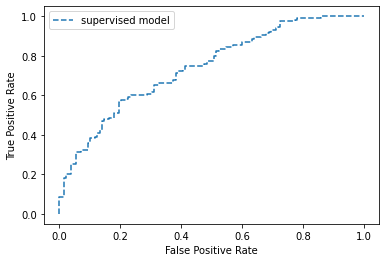

accuracy: 0.6584362139917695
precision_true: 0.6230769230769231
precision_fake: 0.6991150442477876
recall_true: 0.7043478260869566
recall_fake: 0.6171875
f1score_true: 0.6612244897959184
f1score_fake: 0.6556016597510373
Binary_loss 0.9809116
train Data_Size: (2190, 100)
test Data_Size: (243, 100)
Train Label count: True, Fake 1126 1064
Test Label count : True, Fake 133 110
Training supervised Model...
Epoch 1/15
26/26 [==============================] - 13s 507ms/step - loss: 0.6924 - accuracy: 0.5268 - val_loss: 0.6905 - val_accuracy: 0.5730
Epoch 2/15
26/26 [==============================] - 13s 488ms/step - loss: 0.6887 - accuracy: 0.5968 - val_loss: 0.6886 - val_accuracy: 0.5912
Epoch 3/15
26/26 [==============================] - 13s 491ms/step - loss: 0.6842 - accuracy: 0.6297 - val_loss: 0.6860 - val_accuracy: 0.5785
Epoch 4/15
26/26 [==============================] - 13s 483ms/step - loss: 0.6735 - accuracy: 0.6425 - val_loss: 0.6785 - val_accuracy: 0.5712
Epoch 5/15
26/26 [=====

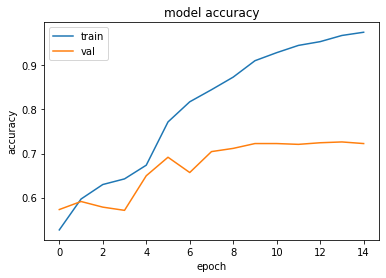

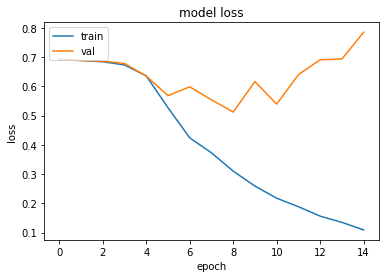

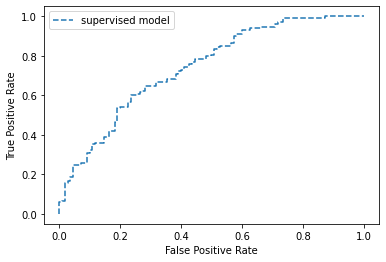

accuracy: 0.6707818930041153
precision_true: 0.7387387387387387
precision_fake: 0.6136363636363636
recall_true: 0.6165413533834586
recall_fake: 0.7363636363636363
f1score_true: 0.6721311475409835
f1score_fake: 0.6694214876033058
Binary_loss 0.9487802
train Data_Size: (2190, 100)
test Data_Size: (243, 100)
Train Label count: True, Fake 1128 1062
Test Label count : True, Fake 131 112
Training supervised Model...
Epoch 1/15
26/26 [==============================] - 14s 541ms/step - loss: 0.6929 - accuracy: 0.5201 - val_loss: 0.6911 - val_accuracy: 0.5839
Epoch 2/15
26/26 [==============================] - 13s 485ms/step - loss: 0.6902 - accuracy: 0.6078 - val_loss: 0.6893 - val_accuracy: 0.6077
Epoch 3/15
26/26 [==============================] - 13s 489ms/step - loss: 0.6875 - accuracy: 0.6425 - val_loss: 0.6876 - val_accuracy: 0.6204
Epoch 4/15
26/26 [==============================] - 13s 486ms/step - loss: 0.6814 - accuracy: 0.6443 - val_loss: 0.6821 - val_accuracy: 0.6004
Epoch 5/15
26/

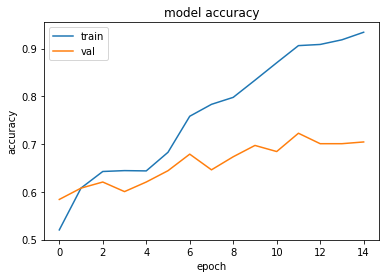

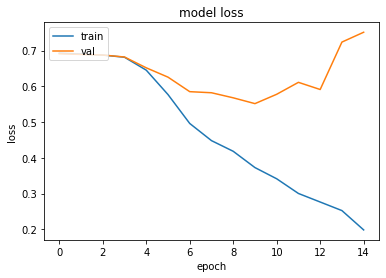

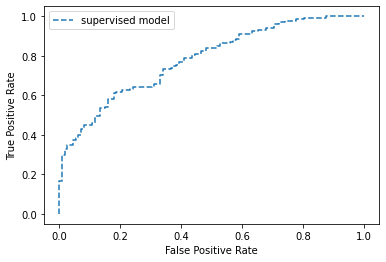

accuracy: 0.6872427983539094
precision_true: 0.6870748299319728
precision_fake: 0.6875
recall_true: 0.7709923664122137
recall_fake: 0.5892857142857143
f1score_true: 0.7266187050359713
f1score_fake: 0.6346153846153846
Binary_loss 0.7352001
train Data_Size: (2190, 100)
test Data_Size: (243, 100)
Train Label count: True, Fake 1127 1063
Test Label count : True, Fake 132 111
Training supervised Model...
Epoch 1/15
26/26 [==============================] - 14s 526ms/step - loss: 0.6927 - accuracy: 0.5347 - val_loss: 0.6923 - val_accuracy: 0.5328
Epoch 2/15
26/26 [==============================] - 13s 490ms/step - loss: 0.6912 - accuracy: 0.5968 - val_loss: 0.6915 - val_accuracy: 0.5547
Epoch 3/15
26/26 [==============================] - 13s 485ms/step - loss: 0.6895 - accuracy: 0.6315 - val_loss: 0.6903 - val_accuracy: 0.5785
Epoch 4/15
26/26 [==============================] - 13s 482ms/step - loss: 0.6863 - accuracy: 0.6419 - val_loss: 0.6885 - val_accuracy: 0.5675
Epoch 5/15
26/26 [========

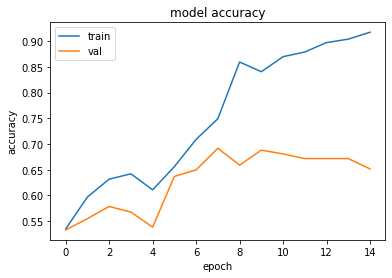

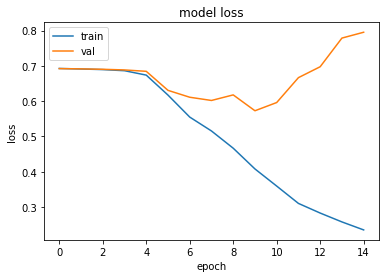

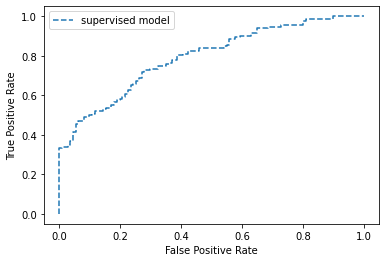

accuracy: 0.6954732510288066
precision_true: 0.7685185185185185
precision_fake: 0.6370370370370371
recall_true: 0.6287878787878788
recall_fake: 0.7747747747747747
f1score_true: 0.6916666666666667
f1score_fake: 0.6991869918699187
Binary_loss 0.74046093
finished


In [ ]:
from sklearn.model_selection import KFold

if __name__ == '__main__':
    lr=0.0001
    epochs=15
    batch_size= 64
    #for mean teacher 
    ratio =0.5
    alpha=0.99 #(0.90-0.99)
    maxlen=100
    n_split=10

    x_train, y_train, x_test, y_test, x_unlabel = loading_data()
    x_train, x_test, x_unlabel, vocab_size, tokenizer = tokenization(x_train,x_test, x_unlabel, maxlen)
    X = np.concatenate((x_train, x_test))
    Y = np.concatenate((y_train, y_test))
    
    for train_index,test_index in KFold(n_split).split(X):
        x_train,x_test=X[train_index],X[test_index]
        y_train,y_test=Y[train_index],Y[test_index]
        print("train Data_Size:",  np.shape(x_train))
        print("test Data_Size:",  np.shape(x_test))
        print('Train Label count: True, Fake', np.count_nonzero(y_train==1),np.count_nonzero(y_train==0))
        print('Test Label count : True, Fake', np.count_nonzero(y_test==1),np.count_nonzero(y_test==0))
        # meanteacher=train_MeanTeacher(epochs, batch_size, alpha, lr, ratio,x_train, y_train, x_test, y_test, x_unlabel,vocab_size, tokenizer,maxlen)
        model=train_supervised(epochs,batch_size,lr,x_train,y_train,x_test,y_test,maxlen,vocab_size)

        tf.keras.backend.clear_session()

       



  
    # for i in range(0,100):

    #     x_train, y_train, x_test, y_test = Kfold_crossvalidation(x_train,y_train,x_test,y_test)

    #     print("train Data_Size:",  np.shape(x_train))
    #     print("test Data_Size:",  np.shape(x_test))
    #     print('Train Label count: True, Fake', np.count_nonzero(y_train==1),np.count_nonzero(y_train==0))
    #     print('Test Label count : True, Fake', np.count_nonzero(y_test==1),np.count_nonzero(y_test==0))
    #     # train_supervised(epochs, batch_size, lr,x_train, y_train, x_test, y_test,maxlen,vocab_size)
    #     train_MeanTeacher(epochs, batch_size, alpha, lr, ratio,x_train, y_train, x_test, y_test, x_unlabel,vocab_size, tokenizer,maxlen)
    #     # resetting the environment
    #     tf.keras.backend.clear_session()
        
    print('finished')